In this module, we will be optimising the operation of a car to minimise fuel consumption.

# Model

The cars dynamics follows a simple dynamical law:

$$
m\frac{dv(t)}{dt} = u(t) - \mu(t) - F_w(t)
$$



where
 - $u(t)$ is the force that is generated by the engine
 - $\mu(t)$ is the resitance force
 - $v(t)$ is the velocity of the car
 - $F_w(t)$ is the wind force
 - $m$ is the mass of the car

The car will have a cruise control setting, $v_{s}$. In order to reach this setting, the car is free to control the acceleraation u(t). 

The resitance force is made up of rolling friction and aerodynamic drag:

$$
\mu(t) = k_0(1-\exp^{-v(t)})+k_1v(t)^2
$$

The amount of instantaneous fuel burn, $\zeta(t)$, of the car is proportional to $u(t)$:

$$
\zeta(t) = \alpha_0 + \alpha_1 u(t)
$$
 
where $\alpha_0$ can be interpreted as the idle fuel burn. 

# Control Objective

The control objective is to control $u(t)$ such that the velocity is $v_s$


# Strategic optimisation

As a driver, the best speed will be the speed that maximises intergated fuel efficiency, $\int_0^T \eta(t) dt$. More formally, $\eta(t)$ is defined as the amount of fuel burned per unit distance travelled. We can derive the equation of this over a finite time horizon, $T$, and take the limit as $T$-> 0 to obtain the instantaneous value:

$$
\eta(t) =\lim_{T->0} \frac{\int_0^T \zeta(t) dt}{\int_0^Tv(t)dt} = \frac{\zeta(t)}{v(t)}
$$

For the special case of constant speed at $v_s$ and constant head wind, $F_w(t) = H$ then we can derive the following expression for $\eta(t)$



$$
\eta(t) =\frac{\alpha_0 + \alpha_1 u(t)}{v_s}\\
=\frac{\alpha_0 + \alpha_1 (\mu(t) + F_w(t)) }{v_s}\\
=\frac{\alpha_0 + \alpha_1 (k_0(1-\exp^{-v(t)})+k_1v_s^2 + H) }{v_s}\\
\approx \frac{\alpha_0 + \alpha_1 (k_0+k_1v_s^2 + H) }{v_s}\\
=\frac{\alpha_0 + \alpha_1(k_0+H) + \alpha_1k_1v_s^2) }{v_s} \\
=\frac{\alpha_0 + \alpha_1(k_0+H) }{v_s} + \alpha_1k_1v_s
$$


The following expression is minimised at:

$$
\eta_{min} = \sqrt{\frac{\alpha_0 + \alpha_1(k_0+H)}{\alpha_1k_1}}
$$

# Problem

We know the values of $H$, $\alpha_0$, $\alpha_1$ and $k_1$.
The problem though is that we only know nominal value of $k_0$ , which changes with the temperature. 

As the driver, out objective is to minimise overall fuel consumption. Theoretically if I could predict the road condition ahead of time, then I would be able to adjust my cruising speed set point to accomodate. 

This is what this notebook will explore. 

We will start with historical data of the car (see Finite Difference Method 3 with NN-Temperature variation.ipyn). This will give us historical car data (observational data), of how the care responded in different temperature conditions. We will use this data to infer the relationship temperature and friction coefficient (the latter for which we do not have data).

We will then use this inferred relationship + the forecasted temperature to make a better set point decision of the crusing speed. We will compare our results to the nominal crusing speed set by the manufacturer of the car. 


# Libraries

In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import pandas as pd

# Data

In [2]:
car_data = pd.read_csv('car_example.csv')
car_data

,Unnamed: 0,time,temperature,displacement,velocity,force,friction_0,wind
0,0,0.0,20.000000,0.000000,0.000000,100.0,48.675329,0.0
1,1,1.0,19.582775,0.096977,0.191134,101.0,55.235344,0.0
2,2,2.0,18.510887,0.376891,0.366252,102.0,47.546286,0.0
3,3,3.0,17.704781,0.828729,0.535708,103.0,49.921721,0.0
4,4,4.0,17.439524,1.445175,0.695738,104.0,45.178275,-0.0
...,...,...,...,...,...,...,...,...
1995,1995,1995.0,11.032870,40392.979197,21.261970,0.0,13.026786,0.0
1996,1996,1996.0,12.849770,40414.178109,21.136051,0.0,30.569714,-0.0
1997,1997,1997.0,13.213347,40435.234203,20.976387,151.0,26.776541,0.0
1998,1998,1998.0,13.337124,40456.285682,21.126352,152.0,38.044492,-0.0


## Visualising the car data

In [3]:
time_data =  car_data['time']
temperature_data = car_data['temperature']
velocity_data = car_data['velocity']
force_data = car_data['force']

Text(0, 0.5, 'Temperature (degrees)')

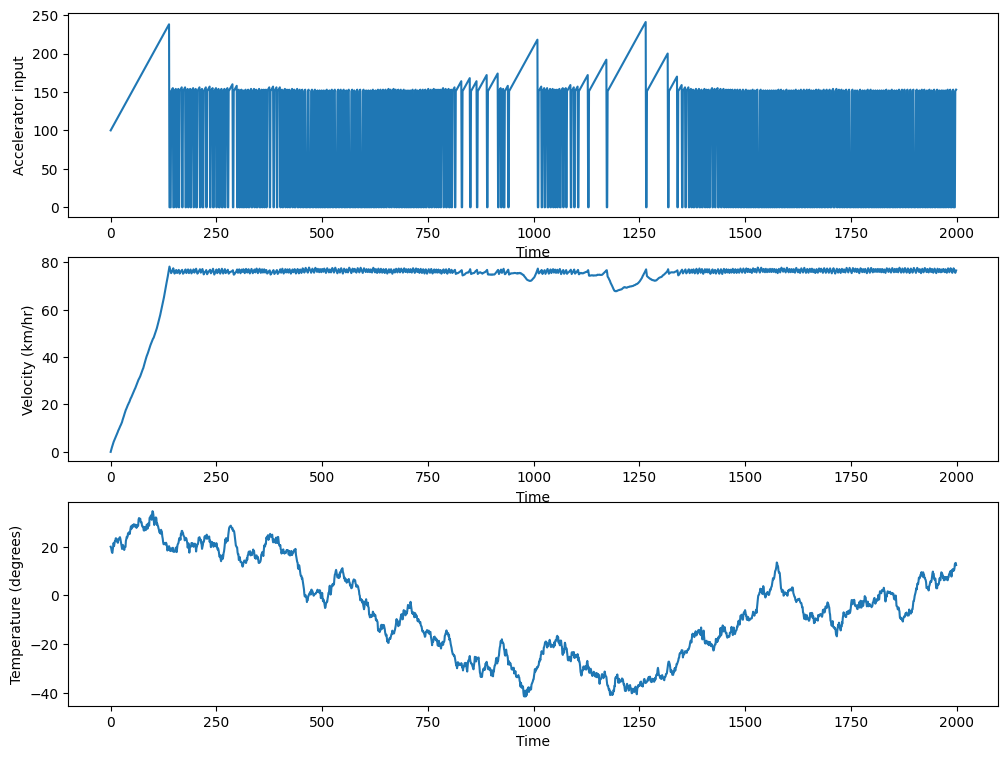

In [4]:
fig,ax = plt.subplots(3,1, figsize=(12, 9))

ax[0].plot(time_data,force_data)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Accelerator input")    

ax[1].plot(time_data,velocity_data*3.6)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Velocity (km/hr)")    

ax[2].plot(time_data,temperature_data)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Temperature (degrees)")    

Interesting. Is there any relationships between temperature and the optimal speed?


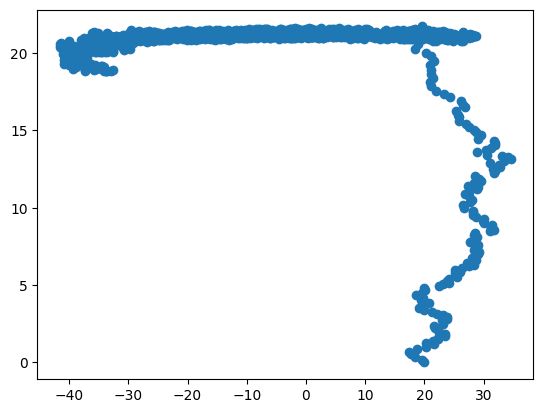

In [5]:
plt.plot(temperature_data,velocity_data,'o')

Of course there isn't. The system is being controlled to stay at the same speed irrespective of the temperature. We need to understand what the inputs are doing for it to stay at the right speed.

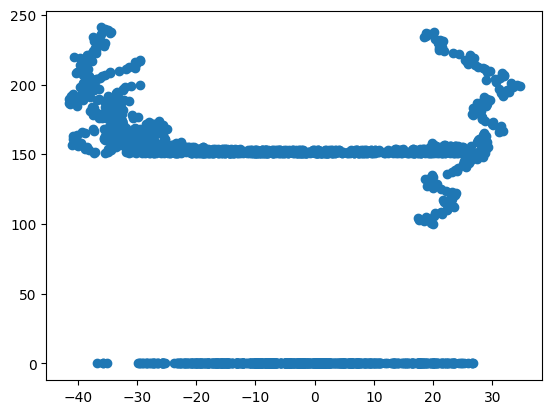

In [6]:
plt.plot(temperature_data,force_data,'o')

This is too hard to understand. We won't be able to see the relationship in simple 2d scatter plots because it doesn't take into account the dynamics. 

# Inferring friction coefficient from a dynamic model

Let's now infer the friction coefficicient as it changes with temperature from a dynamic model

Let us discretise time as $t_i$ for $i$ between $0$ and $N$. 

Let 
$$
K_i = K(t_i)
$$

be our unknown parameters that we wish to solve for

Then the discrete loss function will be:

$$
L_i = \frac{M_c V_c}{T_c}(\frac{v_{i+1} - v_{i-1}}{2\Delta t}) - (U_c u_i - (K_i(1-e^{-V_cv_i}) + \frac{50}{450}V_c^2v_i^2) \quad \forall \quad i = 1...N-1
$$

on the boundary we need to use the forward and backward derivative (https://en.wikipedia.org/wiki/Finite_difference):

$$
L_0 = \frac{M_c V_c}{T_c}(\frac{v_{1} - v_{0}}{\Delta t}) - (U_c u_0 - (K_0(1-e^{-V_cv_0}) + \frac{50}{450}V_c^2v_0^2) 
$$
 and 
 
$$
L_N =  \frac{M_c V_c}{T_c}(\frac{v_{N} - v_{N-1}}{\Delta t}) - (U_c u_N - (K_N(1-e^{-V_cv_N}) + \frac{50}{450}V_c^2v_N^2)
$$

Which can be written in compact vector form as:

$$
\textbf{L} = \frac{M_c V_c}{T_c\Delta t}\textbf{A}\textbf{v} -(U_c \textbf{u} - (\textbf{K}(1-e^{-V_c \textbf{v}}) + \frac{50}{450}V_c^2\textbf{v}^2)
$$

where $A$ is

$$
 \begin{bmatrix}
-1 & 1 & 0 & 0 \\
-\frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & .. & ... & 0 \\
0 & -\frac{1}{2} & 0 &\frac{1}{2} \\
0 & 0 & -1 & 1 
\end{bmatrix} 
$$
(or could take a different form if we use a different type of finite differencing)
 

and our goal is to minimise $L^T L$


Modification

We can modify our fomulation by restricting K to only vary once every J points. We can implement this in the folloinwg way:

Suppose $\textbf{K}$ is a vector of length $floor(K/J)$ with index h. left F map the hth point onto the ith point. Then the effective K is:  


$$
K_{eff} = \textbf{F}\textbf{K} 
$$

In [7]:
a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
aero_coeff = 50/450

In [8]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam
import itertools

In [9]:
def create_A(N,method = "central"):
    if method == "central":
        # Setting up the A matrix (central differcing)
        A = numpy.zeros((N,N))
        np.fill_diagonal(A[1:], -0.5)
        np.fill_diagonal(A[:,1:], 0.5)
        A[0,0] = -1
        A[0,1] = 1
        A[N-1,N-1] = 1
        A[N-1,N-2] = -1
        A = torch.from_numpy(A).float()
    elif method == "forward":
        # Setting up the A matrix (forward differencing)
        A = numpy.zeros((N,N))
        np.fill_diagonal(A, 1)
        np.fill_diagonal(A[1:], -1)
        A[0,0] = -1
        A[0,1] = 1
        A[N-1,N-1] = 1
        A[N-1,N-2] = -1
        A = torch.from_numpy(A).float()
    return A

In [10]:
time_data_np =  np.array(car_data['time'])[:,None]
temperature_data_np = np.array(car_data['temperature'])[:,None]
velocity_data_np = np.array(car_data['velocity'])[:,None]
force_data_np = np.array(car_data['force'])[:,None]

In [11]:
N = len(time_data_np)

# Normalising constants. We can choose these to be whatever we want. 
Mc = m
Tc = len(time_data_np)
Vc = 80.0/3.6
Uc = 250.0
delt = ((time_data_np[1] - time_data_np[0]) / Tc)[0]

# Get the data from the simulation
t_interior = torch.from_numpy(time_data_np).float()
t_interior = t_interior.clone()/Tc
sensor_data = torch.from_numpy(np.hstack((velocity_data_np,force_data_np))).float().div(torch.tensor([[Vc,Uc]])).float()
temperature_data = torch.from_numpy(temperature_data_np).float()

# Create A
A = create_A(N)

In [12]:
t_interior

tensor([[0.0000e+00],
        [5.0000e-04],
        [1.0000e-03],
        ...,
        [9.9850e-01],
        [9.9900e-01],
        [9.9950e-01]])

In [13]:
sensor_data[:,1][:,None]

tensor([[0.4000],
        [0.4040],
        [0.4080],
        ...,
        [0.6040],
        [0.6080],
        [0.6120]])

In [14]:
temperature_data

tensor([[20.0000],
        [19.5828],
        [18.5109],
        ...,
        [13.2133],
        [13.3371],
        [12.4543]])

In [15]:
# Setting up the friction approximator
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

In [16]:

# Setting up the calculation
def compute_loss(fric_approx,temp_data): 
    vel = sensor_data[:,0][:,None].float()
    u = sensor_data[:,1][:,None].float()
    K_approx = fric_approx(temp_data)
    L = torch.mm(Mc*Vc/Tc/delt*A,vel) - (Uc*u - (K_approx*(1-torch.exp(-Vc*vel)) + aero_coeff*Vc*vel*Vc*vel ))
    loss = torch.sqrt(torch.mm(L.transpose(0,1),L).squeeze())
    return loss
    
def optimise(optimiser,fric_approx,temp_data):
    optimiser.zero_grad()
    loss = compute_loss(fric_approx,temp_data)
    loss.backward()
    optimiser.step()
    return loss

In [17]:
lr = 0.01
epochs = 30000
Kapprox = Friction_approximator(2,6)
learnable_params = list(Kapprox.parameters())
k_optimizer = Adam(learnable_params, lr=lr)

In [18]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    loss = optimise(k_optimizer,Kapprox,temperature_data)
    if i % 1000==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy())
        print(i,loss.detach().numpy())

0 3434.4326
1000 2545.81
2000 1828.8322
3000 1734.7068
4000 1716.2981
5000 1705.5406
6000 1702.6406
7000 1701.8971
8000 1701.3789
9000 1702.0469
10000 1701.2767
11000 1702.4774
12000 1701.2223
13000 1700.8759
14000 1700.6829
15000 1700.6658
16000 1700.6517
17000 1700.6362
18000 1700.6185
19000 1700.5977
20000 1700.915
21000 1700.6078
22000 1700.375
23000 1700.1992
24000 1699.0437
25000 1698.3462
26000 1698.173
27000 1698.1223
28000 1698.0587
29000 1697.9906


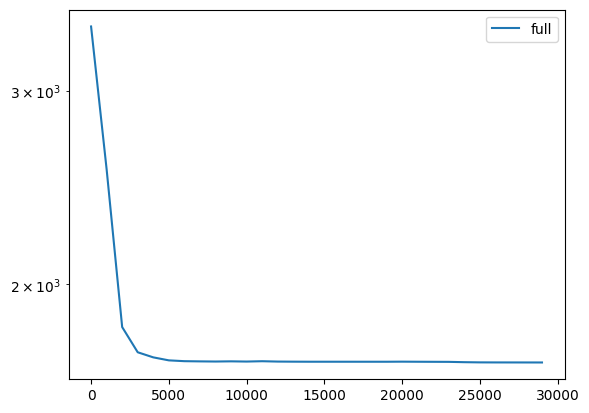

In [19]:
plt.figure()
plt.plot(iteration_vector,loss_vector,label = 'full')
plt.yscale('log')
plt.legend()

okay looks like we have convergence. let's now understand how the temperature and friction varied, by plotting it on a scatter plot. We will also plot the true friction over the top (normally we don't have this).

<Figure size 640x480 with 0 Axes>

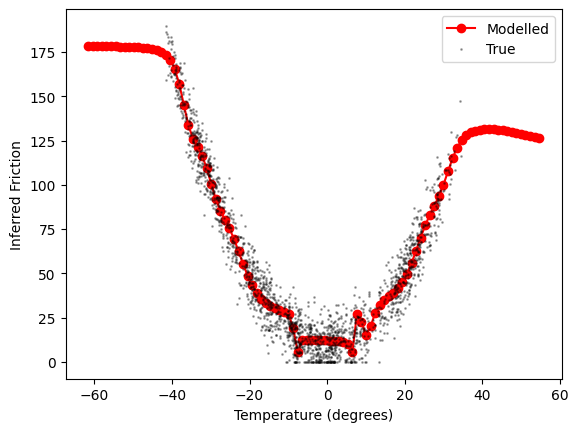

In [20]:
plt.figure()
# NOw interrogate the R approximator
t_data = torch.linspace(min(temperature_data)[0]-20, max(temperature_data)[0]+20, steps=100).view(-1, 1)
with torch.no_grad():
    r_prediction = Kapprox(t_data).numpy()
    
true_k = car_data['friction_0']
plt.figure()
plt.plot(t_data,r_prediction,'o-r',label = "Modelled")
plt.plot(temperature_data,true_k,'ko',label = "True",alpha = 0.3,markersize = 1)
plt.ylabel('Inferred Friction')
plt.xlabel('Temperature (degrees)')

plt.legend()

# Using our inference to help optimise a set point

Now that we know the friction coefficient and it's relationships with temperature, let's use this info to optimise our control of the car

Let's assume that our parameters remain the same

$$
a_0 = 0 \\
a_1 = 1 \\
m = 500 \\
k1 = 50/450 \\
H = 0
$$

Let us also assume that the temperature forecast in the next 2000 seconds is:

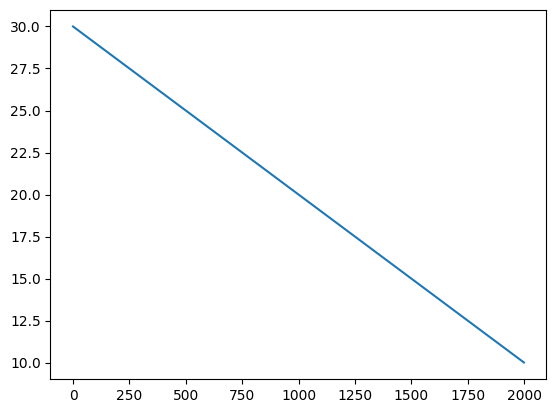

In [21]:
time = np.array(list(range(0,2000)))
temp_forecast = 30.0-0.01*time
plt.plot(time,temp_forecast)

Now, according to our model, assuming, the best speed to operate at will be:
    
$$
\eta_{min} = \sqrt{\frac{\alpha_0 + \alpha_1(k_0+H)}{\alpha_1k_1}} = \sqrt{\frac{k_0(T_f)}{k_1}}
$$
where $T_f$ is the forecasted temperature and $k_0(T_f)$ is our neural network

In [51]:
a_0 = 0
a_1 = 1
m = 500
k1 = 50/450
H = 0

# Defining the constants
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k0 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m )
model.set_rhs('x',x_next)
model.setup()

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)


# Setting up the friction. Friction is a quadraticve function of temperature ( we don't know htis before hand)
Tc = 2000
temperature_forecast = temp_forecast
def friction(temp):
    return 0.1*temp**2 + 10 + 0.01*temp

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['friction'] = max(0,friction(temperature_forecast[int(np.floor(t_now))]) +10*np.random.normal(0,1))
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

simulator.x0 = np.array([0,0])

We'll use a simple expert controller

In [52]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = (150 + 1)*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = (current_force + 1)*np.ones((1,1))
    else:
        u0 = 0*np.ones((1,1))
    return u0

In [53]:
def predict_k0(nn,temperature):
    temperature = temperature*torch.ones((1,1))
    with torch.no_grad():
        r_prediction = nn(temperature).numpy()
    return float(r_prediction[0])

predict_k0(Kapprox,10.0)

15.114120483398438

In [54]:
v_s_initial = np.sqrt(predict_k0(Kapprox,temp_forecast[0]) / k1)
best_u = predict_k0(Kapprox,temp_forecast[0])*(1-np.exp(-v_s_initial)) + 50/450*v_s_initial**2
best_u

200.48222351073312

In [55]:
u0 = best_u*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(2000):
    simulator.make_step(u0)
    
    v_s = np.sqrt(predict_k0(Kapprox,temp_forecast[i]) / k1)
    u0 = expert_controller(simulator,v_s)

In [56]:
def plot_car_trajectory(simulator,sampling_freq):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    friction = simulator.data['_tvp'][::sampling_freq,0]
    force = simulator.data['_u'][::sampling_freq]
        
    ax[0,0].plot(time,states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(time,dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")    
    
    
    ax[1,0].plot(time,friction*(1-exp(-states_sim[:,1])),label = "Rolling")
    ax[1,0].plot(time,k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*force)/1000
    ax[0,2].plot(time,total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(time[1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")    

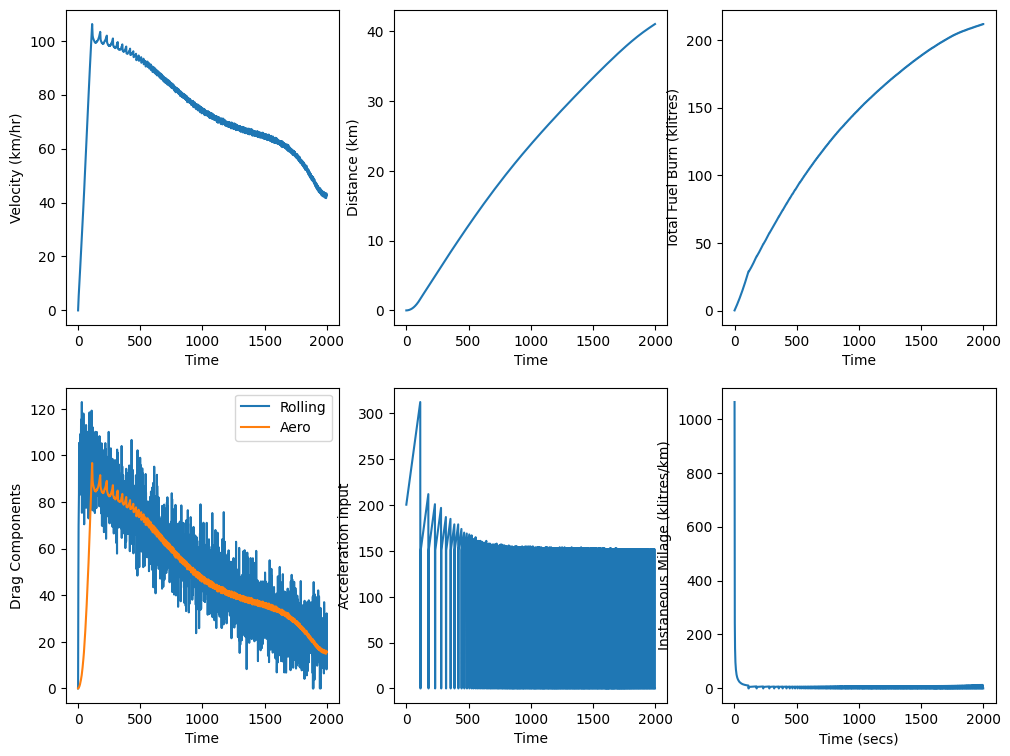

In [57]:
plot_car_trajectory(simulator,1)

In [58]:
def calc_total_fuel_burn_per_km(simulator,burn_in = 500):
    states_sim = simulator.data['_x'][::1]
    force = simulator.data['_u'][::1]
    dist = states_sim[burn_in:,0]/1000
    total_litres = np.cumsum(a_0 + a_1*force[burn_in:])[-1]
    total_km = (dist[-1] - dist[0])
    print(f'{total_litres} litres over {total_km} km')
    return  total_litres/ total_km
optimal_fuel_burn = calc_total_fuel_burn_per_km(simulator)
print(optimal_fuel_burn)

120701.0 litres over 28.844351584222913 km
4184.562778177347


# Now, let's reset and measure fuel burn at a nominal speed

Lets say speed was constant at the average, what would be the fuel burn then?

In [59]:
ave_speed = simulator.data['_x'][:,1].mean()
ave_speed


20.50505550440478

In [60]:
total_distance = simulator.data['_x'][-1,0]
total_distance

41004.2076482798

In [61]:
v_s = ave_speed*1.1
best_u = 50*(1-np.exp(-ave_speed)) + 50/450*ave_speed**2
simulator.reset_history()
simulator.x0 = np.array([0,0])
u0 = best_u*np.ones((1,1)) 
for i in range(2000):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)
    if simulator.data['_x'][-1,0]>total_distance:
        print("max_distance_reached")
        break

max_distance_reached


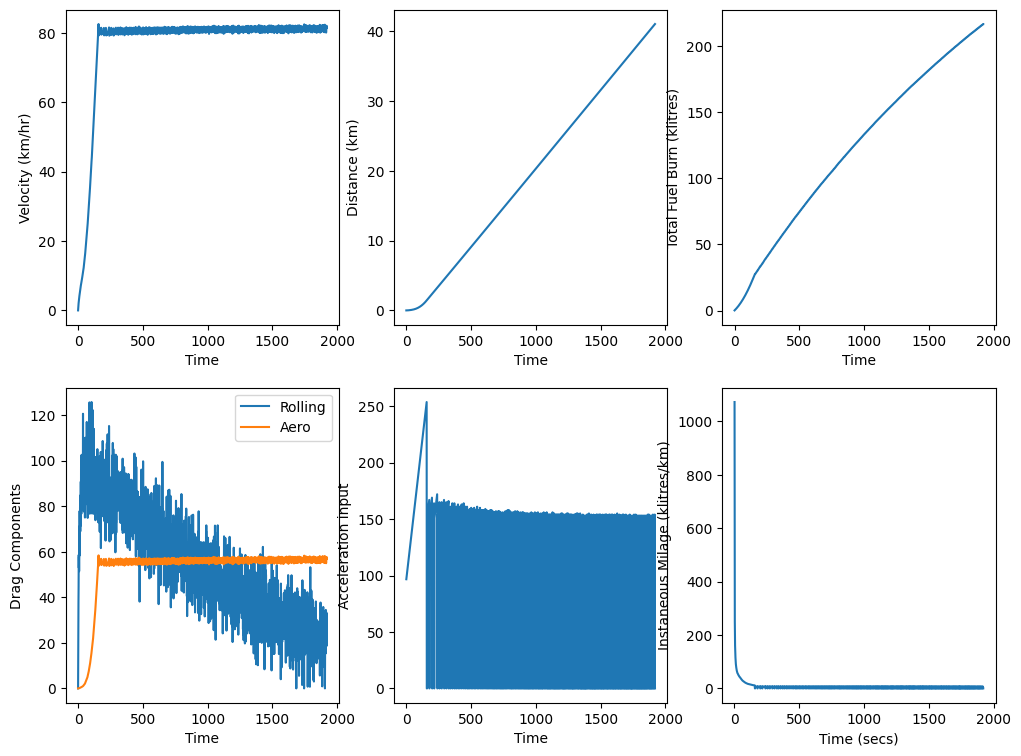

In [62]:
plot_car_trajectory(simulator,1)

In [63]:
sub_optimal_fuel_burn = calc_total_fuel_burn_per_km(simulator)
print(sub_optimal_fuel_burn)

142177.0 litres over 31.92577118887086 km
4453.361491532649


In [64]:
total_savings = (optimal_fuel_burn - sub_optimal_fuel_burn)/sub_optimal_fuel_burn
print(total_savings*100)

-6.035861087548789


So we can save 6%!!!

This would probably be higher if I had a perfect controller. 